**Przykład użycia**

In [ ]:
from src.data_structures import *
from src.shortest_path import *
from src.tsa_solver import *
from src.utlis import *

import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple
from datetime import datetime
import pickle

### **Źródło danych** 
Dane zostały pobrane ze strony miasta Wrocław i zapisane w pliku **mpk_data.csv**.  

W zbiorze danych występują przystanki, które mają identyczne nazwy, ale różnią się położeniem geograficznym.  

W dalszej części takie przystanki zostaną:  
- wykryte na podstawie współrzędnych geograficznych oraz nazwy,  
- odpowiednio zaindeksowane

In [ ]:
df = pd.read_csv("mpk_data.csv")
datetime_format = "%H:%M:%S"
df_unique = df[[ 'start_stop' , 'start_stop_lat', 'start_stop_lon']].drop_duplicates()
df_unique['start_stop_index'] = df_unique.index + 1
df = df.drop(columns=['start_stop_index'], errors='ignore')

df = df.merge( df_unique[['start_stop' , 'start_stop_lat', 'start_stop_lon', 'start_stop_index']],
    on=['start_stop' , 'start_stop_lat', 'start_stop_lon'],
    how='left'
)

df.to_csv('mpk_indexed.csv')
graph = load_csv_data('mpk_indexed.csv')
with open('mpk_graph.pickle', 'wb') as f:
    pickle.dump(graph, f)

In [ ]:
with open('mpk_graph.pickle', 'rb') as f:
    graph = pickle.load(f)

route_planer = RoutePlaner(graph)

### **Opis algorytmów**  

Celem zadania było opracowanie algorytmu wyszukiwania optymalnych połączeń między przystankami z wykorzystaniem algorytmów Dijkstry i A*. Algorytm Dijkstry został zaimplementowany jako szczególny przypadek algorytmu A*, w którym heurystyka zawsze zwraca wartość 0. W efekcie eksploracja grafu odbywa się równomiernie, bez preferencji kierunkowych, a wybór trasy opiera się wyłącznie na rzeczywistym czasie przejazdu.  

W przypadku algorytmu A* kluczowe było zastosowanie odpowiednich heurystyk:  

- Heurystyka euklidesowa – wyznacza odległość między przystankiem następnym a docelowym, przeliczając dystans na czas przejazdu na podstawie średniej prędkości autobusu. Wynik jest skalowany przez stały współczynnik dostosowany eksperymentalnie.  
- Heurystyka kierunkowa – oblicza kąt między przystankiem obecnym, następnym a docelowym, nakładając karę, gdy zmiana kierunku przekracza 60°. Dzięki temu ogranicza eksplorację do stożka o kącie 120° skierowanego w stronę celu, co pozwala na szybszą konwergencję.  
- Heurystyka haversine – wykorzystuje rzeczywistą odległość geograficzną między przystankami, a dodatkowo uwzględnia koszt zmiany linii, dodając stałą karę za konieczność oczekiwania na kolejny kurs.  

Modyfikacja algorytmu A* w funkcji `astar_changes` polega na zmianie sposobu obsługi kolejki priorytetowej. Oprócz łącznego szacowanego kosztu (suma rzeczywistego czasu przejazdu i wartości heurystyki) algorytm uwzględnia również liczbę przesiadek. Wprowadzona zmiana pozwala preferować trasy, które nie tylko minimalizują czas podróży, ale także ograniczają liczbę zmian linii, co poprawia komfort pasażera i redukuje czas oczekiwania na przesiadki.

### **Ponizej znajduja sie przykladowe wywolania algorytmow dla danych przystanków**

In [ ]:
start_stop = 'Jagodzińska'
end_stop = 'Kochanowskiego'
departure_time = '10:30:00'

**Algorytm Dijkstry**

In [ ]:
totaltime, route, visited_nodes, visited_connections = route_planer.astar(
    start_stop=start_stop, 
    end_stop=end_stop, 
    departure_time=departure_time,
    heuristic_function=route_planer.zero_heuristic
)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections)

Całkowity czas podróży: 34.0 min
Odwiedzone węzły: 216
Odwiedzone połączenia: 701
+----+---------+----------+----------+-------------------------+----------------------+
|    | Linia   | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 | 110     | 10:30:00 | 10:42:00 | Malinowskiego           | Hubska (Dawida)      |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 | 16      | 10:47:00 | 11:00:00 | Kościuszki              | PL. GRUNWALDZKI      |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 | D       | 11:01:00 | 11:04:00 | Kochanowskiego          | Kochanowskiego       |
+----+---------+----------+----------+-------------------------+----------------------+


### **Algorytm A\* oparty z heurystyką opartą o szacowany czas przyjazdu na podstawie odległości euklidesowej**


In [ ]:

totaltime, route, visited_nodes, visited_connections = route_planer.astar(start_stop=start_stop, 
                                                                          end_stop=end_stop, 
                                                                          departure_time=departure_time,
                                                                          heuristic_function=route_planer.euclidean_distance_heuristic)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections)

Całkowity czas podróży: 35.0 min
Odwiedzone węzły: 78
Odwiedzone połączenia: 278
+----+---------+----------+----------+-------------------------+----------------------+
|    |   Linia | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 |     110 | 10:30:00 | 10:35:00 | Malinowskiego           | Morwowa              |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 |     100 | 10:39:00 | 10:40:00 | Złotostocka             | Złotostocka          |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 |     143 | 10:44:00 | 10:57:00 | Klimasa                 | 8 Maja               |
+----+---------+----------+----------+-------------------------+----------------------+
|  3 |       9 | 11:00:00 | 11:05:00 | Stadion Olimpijski      | Kochanowskiego       |
+----+---------+----------+----------+-

### **Algorytm A\* oparty z heurystyką opartą o szacowany czas przyjazdu na podstawie odległości haversine i zmianach linii**


In [ ]:
totaltime, route, visited_nodes, visited_connections = route_planer.astar(start_stop=start_stop, 
                                                                          end_stop=end_stop, 
                                                                          departure_time=departure_time,
                                                                          heuristic_function=route_planer.haversine_distance_heuristic)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections)

Całkowity czas podróży: 50.0 min
Odwiedzone węzły: 266
Odwiedzone połączenia: 828
+----+---------+----------+----------+-------------------------+----------------------+
|    |   Linia | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 |     110 | 10:30:00 | 10:35:00 | Malinowskiego           | Morwowa              |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 |     100 | 10:39:00 | 10:44:00 | Złotostocka             | Karwińska            |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 |       5 | 10:46:00 | 10:48:00 | Park Wschodni           | Armii Krajowej       |
+----+---------+----------+----------+-------------------------+----------------------+
|  3 |     143 | 11:05:00 | 11:14:00 | Międzyrzecka            | 8 Maja               |
+----+---------+----------+----------+

### **Algorytm A\* oparty z heurystyką opartą o szacowany czas przyjazdu na podstawie kąta i zmianach linii**


In [ ]:

totaltime, route, visited_nodes, visited_connections = route_planer.astar(start_stop=start_stop, 
                                                                          end_stop=end_stop, 
                                                                          departure_time=departure_time,
                                                                          heuristic_function=route_planer.angle_between_heuristic)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections)

Całkowity czas podróży: 34.0 min
Odwiedzone węzły: 64
Odwiedzone połączenia: 229
+----+---------+----------+----------+-------------------------+----------------------+
|    | Linia   | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 | 110     | 10:30:00 | 10:42:00 | Malinowskiego           | Hubska (Dawida)      |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 | 16      | 10:47:00 | 11:00:00 | Kościuszki              | PL. GRUNWALDZKI      |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 | D       | 11:01:00 | 11:04:00 | Kochanowskiego          | Kochanowskiego       |
+----+---------+----------+----------+-------------------------+----------------------+


### **Algorytm A\* oparty z heurystyką opartą na odległości haversine i liczbie zmian linii w kolejce piorytetowej**

In [ ]:

totaltime, route, visited_nodes, visited_connections = route_planer.astar_changes(start_stop=start_stop, 
                                                                          end_stop=end_stop, 
                                                                          departure_time=departure_time)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections)

Całkowity czas podróży: 134.0 min
Odwiedzone węzły: 91
Odwiedzone połączenia: 212
+----+---------+----------+----------+---------------------------+----------------------+
|    | Linia   | Start    | Koniec   | Przystanek początkowy     | Przystanek końcowy   |
+====+=========+==========+==========+===========================+======================+
|  0 | 110     | 10:30:00 | 10:53:00 | Malinowskiego             | GALERIA DOMINIKAŃSKA |
+----+---------+----------+----------+---------------------------+----------------------+
|  1 | D       | 10:55:00 | 11:04:00 | Urząd Wojewódzki (Impart) | Kochanowskiego       |
+----+---------+----------+----------+---------------------------+----------------------+


### **Wyniki algorytmów**

| Heuristic            | Visited Connections | Number of Transfers | Total Time  |
|----------------------|--------------------|---------------------|------------|
| Angle Between       | 481.037383         | 2.831776            | 75.744444  |
| Euclidean Distance  | 687.515439         | 3.745843            | 105.517857 |
| Haversine Changes   | 468.198630         | 1.917808            | 274.576642 |
| Haversine Distance  | 755.247191         | 4.196629            | 90.848921  |
| Zero Heuristic      | 1243.934579        | 3.345794            | 74.515306  |


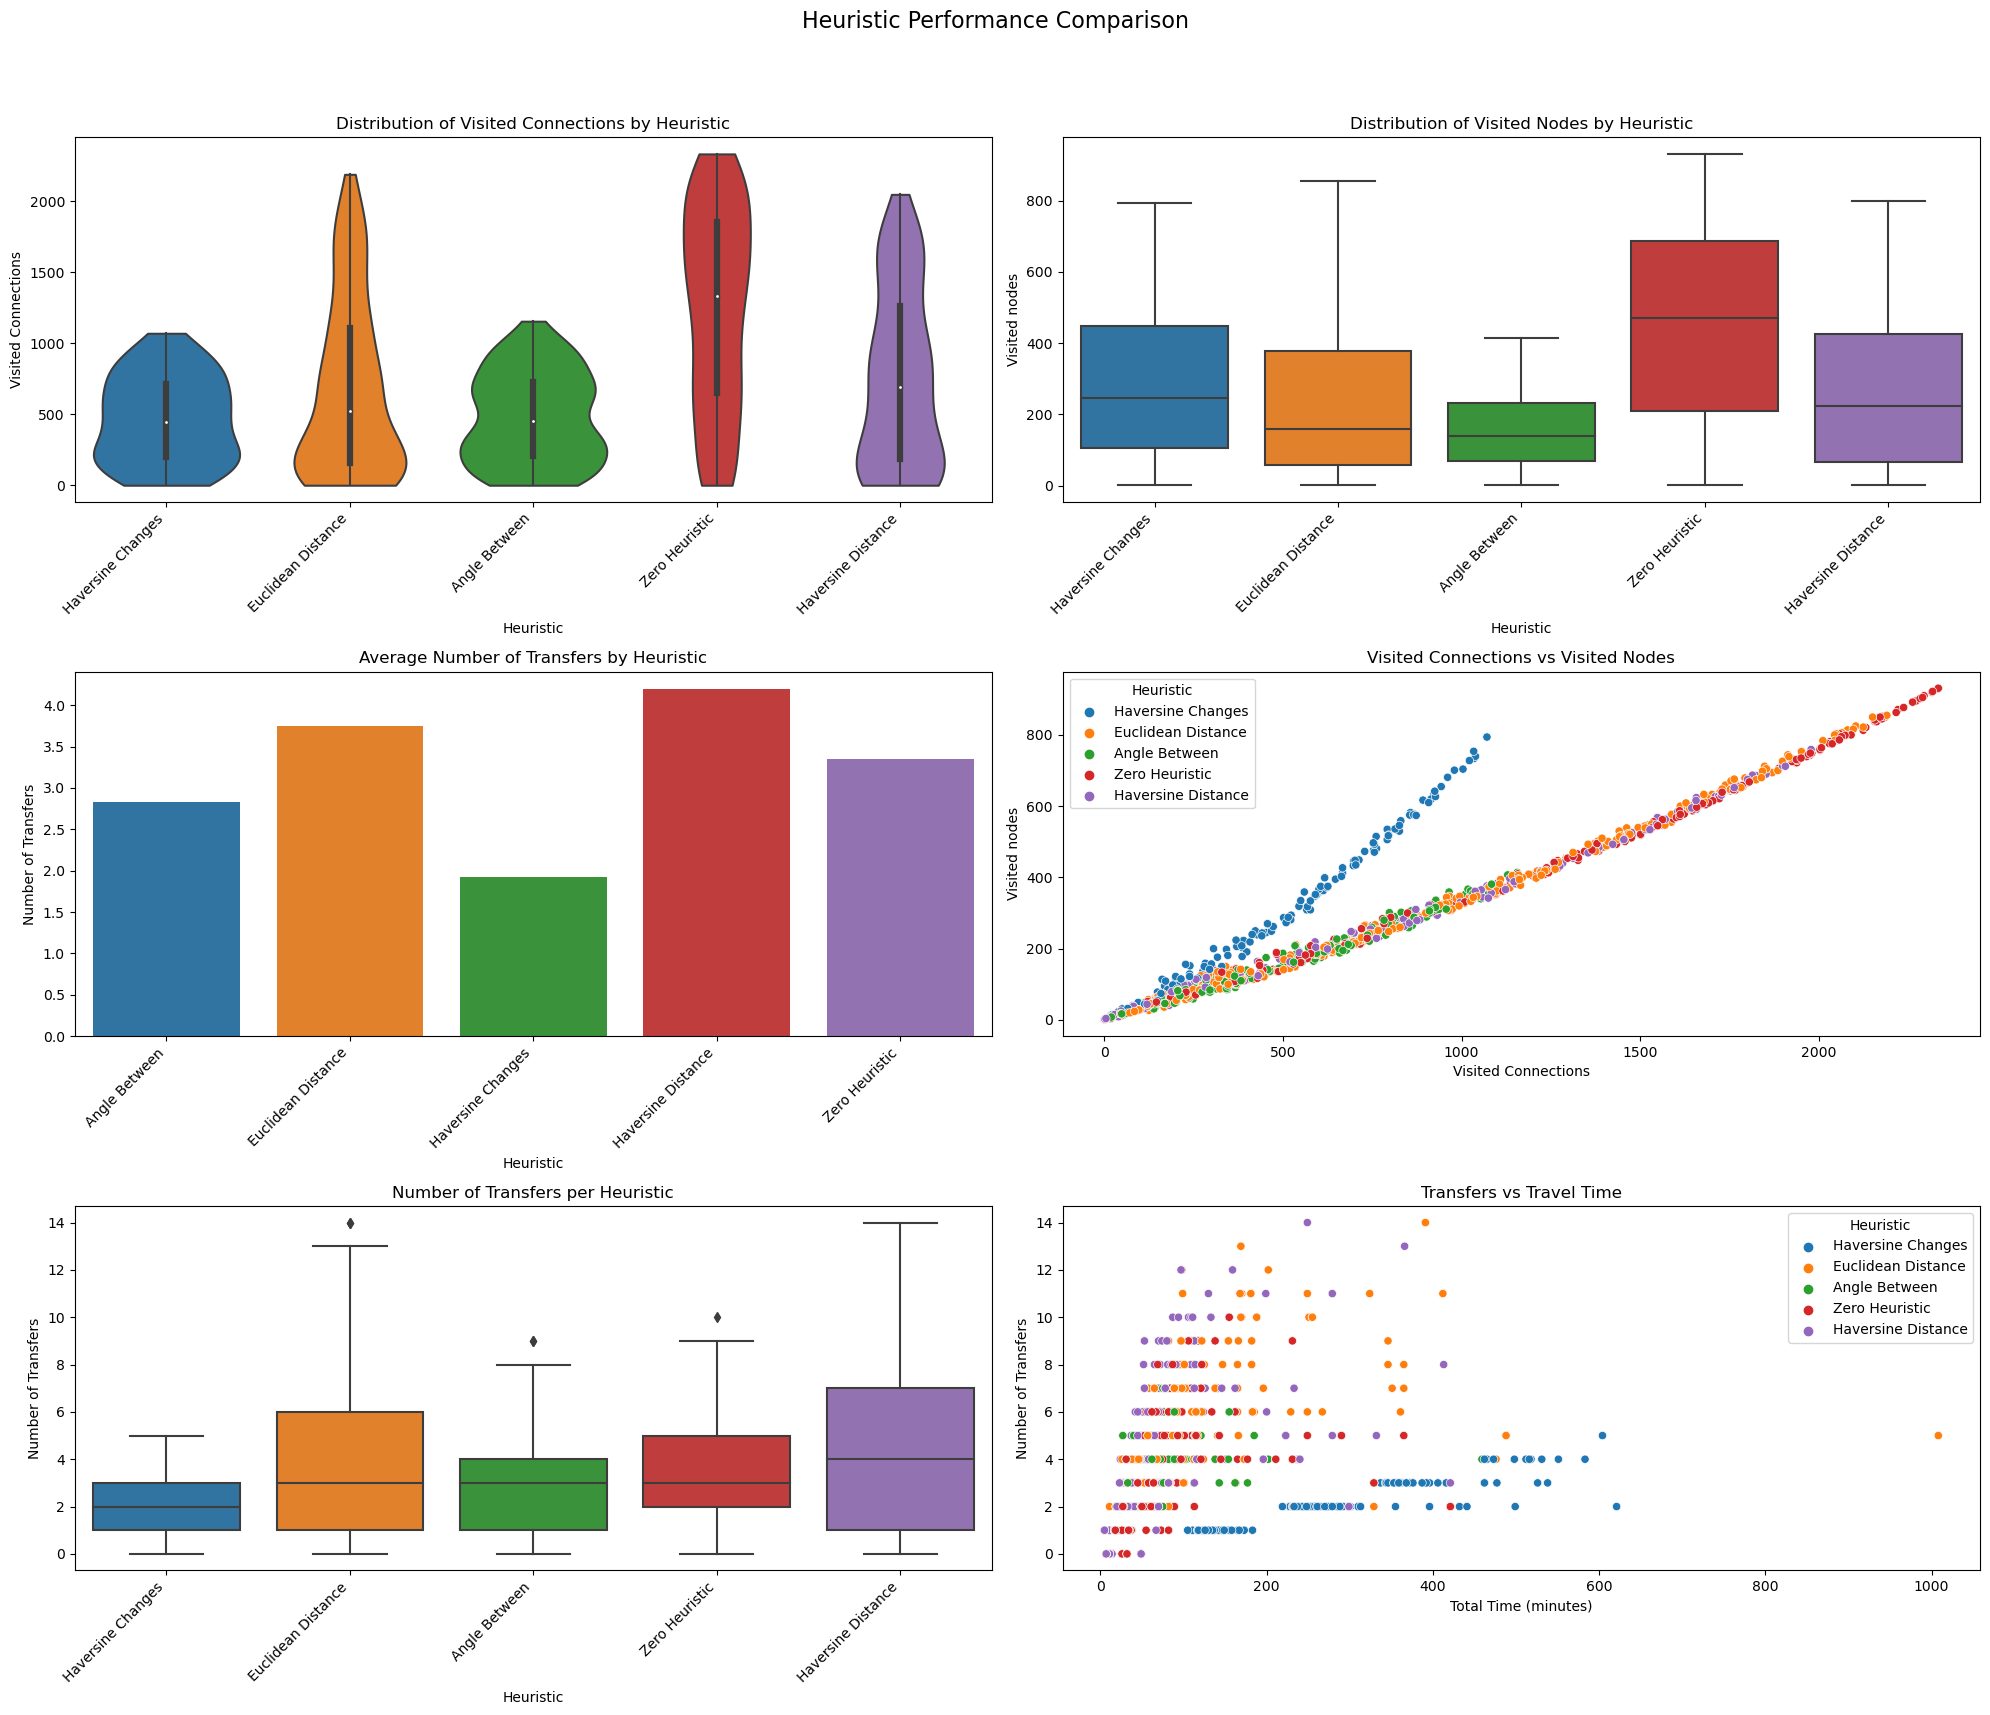

### **Analiza wyników eksperymentu**  

Wyniki testów zostały uzyskane na podstawie 200 losowo wybranych połączeń. Każda z heurystyk wpływała na sposób eksploracji grafu oraz znajdowanie optymalnej ścieżki. Celem analizy jest porównanie ich skuteczności pod względem liczby odwiedzonych wierzchołków i krawędzi, liczby przesiadek oraz całkowitego czasu podróży.  

### **Liczba odwiedzonych krawędzi i wierzchołków**  

Heurystyka oparta na kącie (**Angle Between**) odwiedza najmniejszą liczbę wierzchołków, a liczba odwiedzonych krawędzi jest porównywalna z heurystyką **Haversine Changes**. Jest to zgodne z założeniami – heurystyka ta miała na celu ukierunkowanie eksploracji grafu w stronę przystanku docelowego poprzez stosowanie kar opartych na zmianie kierunku trasy.  

Początkowo heurystyka ta miała minimalizować liczbę przesiadek, i rzeczywiście uzyskane wyniki wskazują na poprawę względem algorytmu Dijkstry oraz innych heurystyk. Jednak pierwotna konstrukcja kolejki priorytetowej ograniczała możliwość efektywnego wyszukiwania tras o najmniejszej liczbie zmian linii.  

Ponieważ różnice w czasie wykonywania algorytmu między poszczególnymi heurystykami nie były znaczące, jako miarę złożoności obliczeniowej przyjęto liczbę odwiedzonych wierzchołków i krawędzi. W tym aspekcie heurystyka **Angle Between** wydaje się najbardziej efektywna, redukując liczbę analizowanych elementów grafu.  

### **Liczba przesiadek**  

Najmniejszą liczbę przesiadek generuje algorytm **Haversine Changes**, który modyfikuje sposób działania kolejki priorytetowej, uwzględniając koszt zmiany linii jako dodatkowy czynnik. Jest to zgodne z jego założeniami – preferuje on trasy z jak najmniejszą liczbą przesiadek, nawet kosztem dłuższego czasu podróży.  

Taka strategia znacząco wpływa na wybór tras – podróże są dłuższe czasowo, ale mają mniej przesiadek. Jest to istotne z perspektywy pasażerów, dla których każda przesiadka wiąże się z ryzykiem opóźnień i dodatkowymi niedogodnościami.  

### **Czas podróży**  

Heurystyki oparte na szacowaniu średniego czasu dotarcia do celu (**Euclidean Distance** i **Haversine Distance**) nie osiągają optymalnych wyników. Wynika to z faktu, że proste modele odległości nie są wystarczająco dokładne w kontekście transportu publicznego. Kręte trasy autobusowe oraz zmienna prędkość pojazdów powodują, że rzeczywisty czas podróży może znacznie odbiegać od szacunków opartych na średnich wartościach.  

Zastosowanie stałej średniej prędkości dla wszystkich linii autobusowych to znaczne uproszczenie. W rzeczywistości różne linie mogą mieć zupełnie inne charakterystyki – np. linie ekspresowe poruszają się szybciej niż linie miejskie zatrzymujące się na każdym przystanku. Aby poprawić skuteczność heurystyki szacującej czas podróży, należałoby uwzględnić dodatkowe informacje, takie jak dane historyczne o prędkościach na poszczególnych odcinkach trasy.  

Mimo to, najlepsze wyniki w tej kategorii osiągają **algorytm Dijkstry oraz heurystyka Angle Between**, uzyskując bardzo zbliżone wartości całkowitego czasu podróży. Warto jednak zaznaczyć, że algorytm Dijkstry charakteryzuje się znacznie większą złożonością obliczeniową.  

**Wizualizacja wyników**  

Dobrą ilustracją podziału algorytmów na dwie grupy – te optymalizujące liczbę przesiadek oraz te minimalizujące czas podróży – jest wykres **Visited Connections vs Visited Nodes**.  

Trzy heurystyki (**Euclidean Distance, Haversine Distance, Angle Between**) wykazują niemal liniową zależność między liczbą odwiedzonych wierzchołków a liczbą odwiedzonych krawędzi. Natomiast **Haversine Changes** wyraźnie się wyróżnia, minimalizując liczbę przesiadek.  

Dla tej samej liczby odwiedzonych wierzchołków algorytm **Haversine Changes** analizuje znacznie mniejszą liczbę krawędzi niż heurystyki optymalizujące czas podróży. Oznacza to, że algorytm ten **ignoruje część połączeń, które wymagałyby zmiany linii**, co dobrze oddaje jego działanie i skuteczność w ograniczaniu liczby przesiadek.  